In [1]:
from pathlib import Path
import copy
from tqdm import tqdm

import torch
import pyscf
import numpy as np
import opt_einsum as oe

from cadft.utils import Grid
from cadft import CC_DFT_DATA, Mol
from cadft.utils import gen_basis

/home/dhem/anaconda3/envs/pyscf/lib/python3.11/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [2]:
# from cadft.utils.mol import name_mol
# name_mol

In [3]:
mol = "ethane"
distance = 0.0000

molecular = copy.deepcopy(Mol[mol])
molecular[0][1] += distance

dft2cc = CC_DFT_DATA(
    molecular,
    name="test",
    basis="STO-3G",
    if_basis_str=True,
)

mf = pyscf.scf.RHF(dft2cc.mol)
mf.kernel()
print(mf.make_rdm1().shape)

[['C', -0.7559999999525115, -7.4141038995629234e-06, -4.102898958090889e-06], ['C', 0.7559999999525115, 7.414103899555937e-06, 4.102898958088492e-06], ['H', -1.1403942593036256, -0.8776472163457668, 0.5281502314567919], ['H', -1.1403942596299452, -0.018597602466389196, -1.024126941245846], ['H', -1.1405114808515184, 0.8962112660692041, 0.49595814200042254], ['H', 1.1403942596299452, 0.018597602466389196, 1.024126941245846], ['H', 1.1405114808515184, -0.8962112660692041, -0.49595814200042254], ['H', 1.1403942593036256, 0.8776472163457668, -0.5281502314567919]]
(16, 16)


In [4]:
mycc = pyscf.cc.CCSD(mf)
mycc.kernel()
dm1_cc = mycc.make_rdm1(ao_repr=True)
dm2_cc = mycc.make_rdm2(ao_repr=True)
e_cc = mycc.e_tot

mdft = pyscf.scf.RKS(dft2cc.mol)
mdft.xc = "b3lyp"
mdft.kernel()
e_dft = mdft.e_tot
dm1_dft = mdft.make_rdm1(ao_repr=True)

grids = Grid(dft2cc.mol)
coords = grids.coords
weights = grids.weights
ao_2 = pyscf.dft.numint.eval_ao(dft2cc.mol, coords, deriv=2)
ao_0 = ao_2[0, :, :]
ao_value = ao_2[:4, :, :]
ao_2_diag = ao_2[4, :, :] + ao_2[7, :, :] + ao_2[9, :, :]

rho_dft = pyscf.dft.numint.eval_rho(dft2cc.mol, ao_value, dm1_dft, xctype="GGA")
rho_cc = pyscf.dft.numint.eval_rho(dft2cc.mol, ao_value, dm1_cc, xctype="GGA")

rho_dft_grids = grids.vector_to_matrix(rho_dft[0])
rho_cc_grids = grids.vector_to_matrix(rho_cc[0])

In [12]:
# data = np.load(f"../data/grids_mrks/data_{mol}_cc-pCVDZ_0_1_{distance:.4f}.npz")
data = np.load(
    f"/run/user/1000/gvfs/sftp:host=hkqai/home/chenzihao/workdir/cadft/data/grids_mrks/data_{mol}_cc-pCVDZ_0_1_{distance:.4f}.npz"
)
# data = np.load(
#     f"/run/user/1000/gvfs/sftp:host=hkqai/home/chenzihao/workdir/cadft/data/grids_mrks/data_{mol}_cc-pcvqz_0_1_{distance:.4f}.npz"
# )

2158


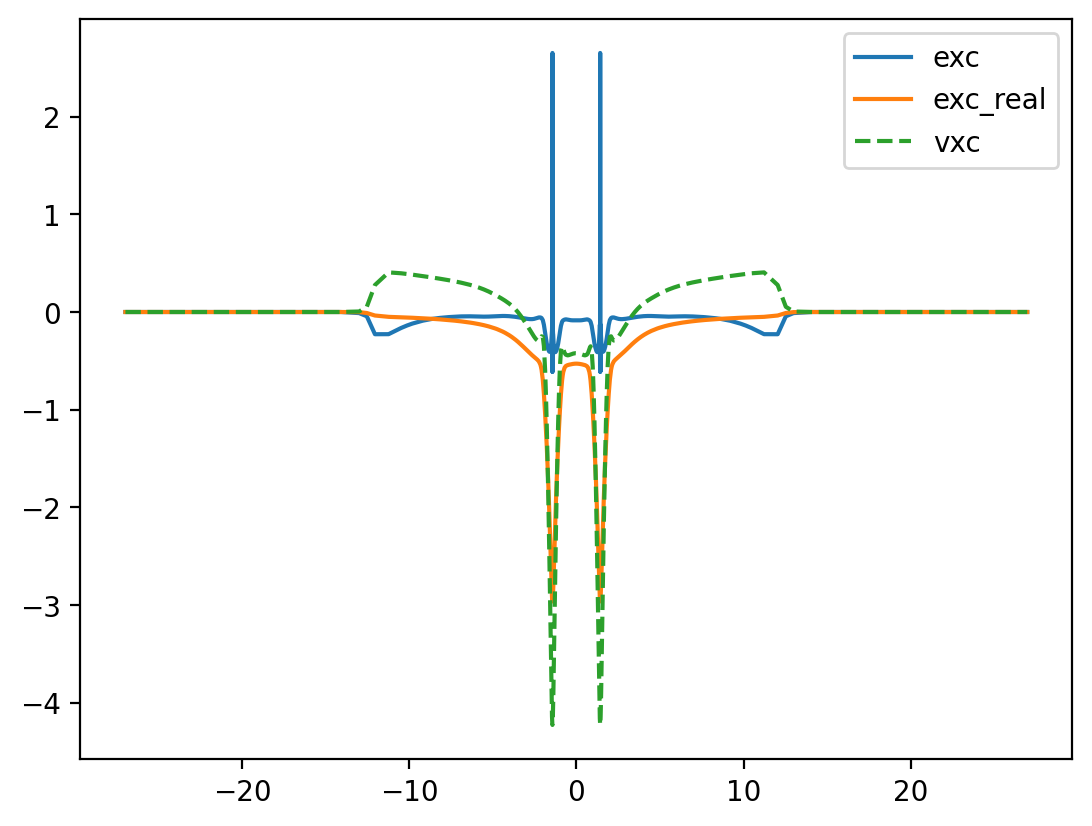

In [13]:
# exc_real = data["exc_over_dm_cc_grids"]
exc_real = data["exc_real"]
exc = data["exc_tr_b3lyp"]
vxc = data["vxc"]

index_ = np.where(
    (np.abs(coords[:, 1] + 5.745029803506404e-05) < 1e-4)
    & (np.abs(coords[:, 2]) < 1e-5)
)
sort_ = np.argsort(coords[:, 0][index_])
x = coords[:, 0][index_][sort_]
y11 = (grids.matrix_to_vector(exc))[index_][sort_]
y12 = (grids.matrix_to_vector(exc_real))[index_][sort_]
y2 = (grids.matrix_to_vector(vxc))[index_][sort_]

plt.plot(x, y11, label="exc")
plt.plot(x, y12, label="exc_real")
plt.plot(x, y2, label="vxc", linestyle="--")
# plt.xlim(-1.5, -1.4)
# plt.xlim(-5, 5)
# plt.ylim(-5, 2.5)

plt.legend(loc="best")
print(len(x))

In [7]:
for i in data.keys():
    print(i)

rho_cc
rho_inv
weights
vxc
exc
exc_real
exc_tr_b3lyp
exc_tr
coords_x
coords_y
coords_z


7500


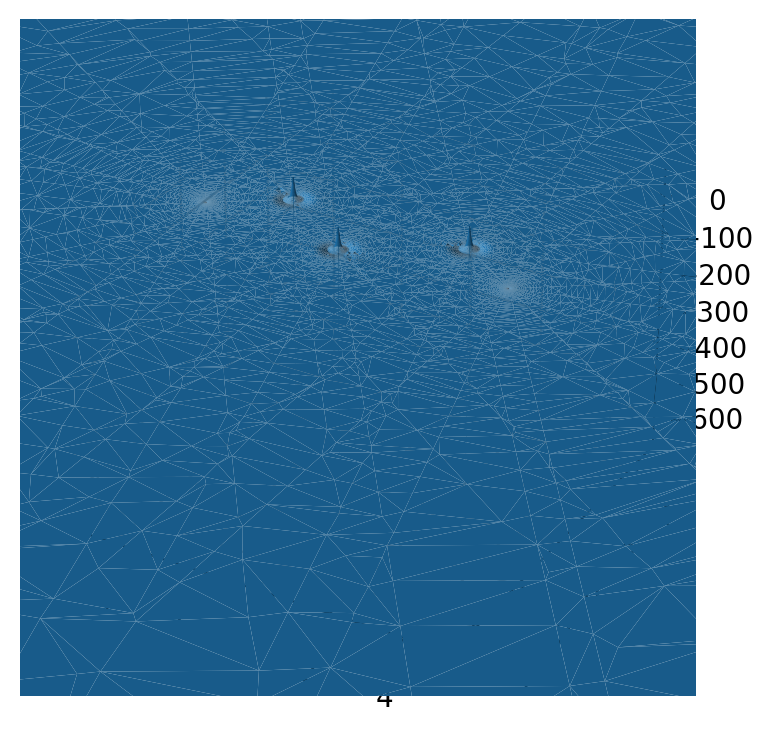

In [5]:
index_ = np.where((np.abs(coords[:, 2]) < 1e-10))
sort_ = np.argsort(coords[:, 0][index_])
x = coords[:, 0][index_][sort_]
y = coords[:, 1][index_][sort_]
# z11 = (grids.matrix_to_vector(exc))[index_][sort_]
z12 = (grids.matrix_to_vector(exc_real))[index_][sort_]
# z2 = (grids.matrix_to_vector(vxc))[index_][sort_]

fig = plt.figure(figsize=plt.figaspect(0.5))

ax = fig.add_subplot(1, 2, 1, projection="3d")
# ax.plot_trisurf(x, y, z11, label="exc")
ax.plot_trisurf(x, y, z12, label="exc_real")
# ax.plot_trisurf(x, y, z2, label="vxc")
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
# ax.set_zlim(-5, 5)
# plt.xlim(1.13, 1.155)

# plt.legend(loc='upper right')
print(len(x))

In [1]:
1 - 1e-3

0.999